# Chapter 7

In [1]:
from control.matlab import *
import control as ct
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] ='sans-serif' #使用するフォント
plt.rcParams['xtick.direction'] = 'in' #x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in' #y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0 #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0 #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 10 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0 # 軸の線幅edge linewidth。囲みの太さ
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['axes.xmargin'] = '0' #'.05'
plt.rcParams['axes.ymargin'] = '0.05'
plt.rcParams['savefig.facecolor'] = 'None'
plt.rcParams['savefig.edgecolor'] = 'None'

In [2]:
def linestyle_generator():
    linestyle = ['-', '--', '-.', ':']
    lineID = 0
    while True:
        yield linestyle[lineID]
        lineID = (lineID + 1) % len(linestyle)

In [3]:
def plot_set(fig_ax, *args):
    fig_ax.set_xlabel(args[0])
    fig_ax.set_ylabel(args[1])
    fig_ax.grid(ls=':')
    if len(args)==3:
        fig_ax.legend(loc=args[2])

In [4]:
def bodeplot_set(fig_ax, *args):
    fig_ax[0].grid(which="both", ls=':')
    fig_ax[0].set_ylabel('Gain [dB]')

    fig_ax[1].grid(which="both", ls=':')
    fig_ax[1].set_xlabel('$\omega$ [rad/s]')
    fig_ax[1].set_ylabel('Phase [deg]')
    
    if len(args) > 0:
        fig_ax[1].legend(loc=args[0])
    if len(args) > 1:
        fig_ax[0].legend(loc=args[1])

## オブザーバ

In [5]:
A = '0 1; -4 5'
B = '0; 1'
C = '1 0'
D = '0'
P = ss(A, B, C, D)
print(P)

A = '0 1; -4 5'
B = '0; 1'
C = '1 0; 0 1'
D = '0; 0'
Ps = ss(A, B, C, D)
print(Ps)

A = [[ 0  1]
 [-4  5]]

B = [[0]
 [1]]

C = [[1 0]]

D = [[0]]

A = [[ 0  1]
 [-4  5]]

B = [[0]
 [1]]

C = [[1 0]
 [0 1]]

D = [[0]
 [0]]



### オブザーバゲインの設計（極配置）

In [6]:
# オブザーバ極
observer_poles=[-15+5j,-15-5j]

# オブザーバゲインの設計（状態フィードバックの双対） 
L = -acker(P.A.T, P.C.T, observer_poles).T
print(L)

[[ -35.]
 [-421.]]


In [7]:
np.linalg.eigvals(P.A + L * P.C)

array([-15.+5.j, -15.-5.j])

In [8]:
# レギュレータ極
regulator_poles = [-5+5j, -5-5j]
# 極配置
F = -acker(P.A, P.B, regulator_poles)
print(F)

[[-46. -15.]]


In [9]:
Gsf = ss(P.A + P.B*F, P.B, np.eye(2), [[0],[0]])
#Obs = ss(P.A+P.B*F+L*P.C, -L, np.eye(2), [[0],[0]] )
Obs = ss(P.A + L*P.C, np.c_[P.B, -L], np.eye(2), [[0,0],[0,0]] )

In [10]:
pole(Obs)

array([-15.+5.j, -15.-5.j])

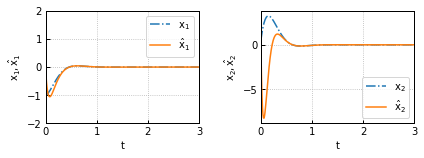

In [11]:
fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

T = np.arange(0, 3, 0.01)
X0 = [-1, 0.5]
x, t = initial(Gsf, T, X0)
ax[0].plot(t, x[:, 0], ls='-.', label='${x}_1$')
ax[1].plot(t, x[:, 1], ls='-.', label='${x}_2$')

# 入力 u = Fx
u = [ [F[0,0]*x[i,0]+F[0,1]*x[i,1]] for i in range(len(x))]
# 出力 y = Cx
y = x[:, 0]
# オブザーバで推定した状態の振る舞い
xhat, t, x0 = lsim(Obs, np.c_[u, y], T, [0, 0])
ax[0].plot(t, xhat[:, 0], label='$\hat{x}_1$')
ax[1].plot(t, xhat[:, 1], label='$\hat{x}_2$')

for i in [0, 1]:
    plot_set(ax[i], 't', '', 'best')
    ax[i].set_xlim([0, 3])

ax[0].set_ylim([-2, 2])
ax[0].set_ylabel('$x_1, \hat{x}_1$')
ax[1].set_ylabel('$x_2, \hat{x}_2$')

fig.tight_layout()
#fig.savefig("obs.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### 出力フィードバック

In [12]:
# 出力フィードバック（オブザーバ＋状態フィードバック）
K = ss(P.A+P.B*F+L*P.C, -L, F, 0)
print('K:\n', K)
print('----------------')
print('K(s)=', tf(K))
 
# フィードバック系
Gfb = feedback(P, K, sign=1)

K:
 A = [[ -35.    1.]
 [-471.  -10.]]

B = [[ 35.]
 [421.]]

C = [[-46. -15.]]

D = [[0]]

----------------
K(s)= 
 -7925 s - 9216
----------------
s^2 + 45 s + 821



(-1.5, 3.5)

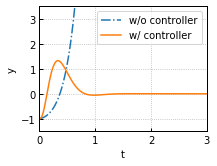

In [13]:
fig, ax = plt.subplots(figsize=(3, 2.3))
Td = np.arange(0, 3, 0.01)

y, t = initial(P, Td, [-1, 0.5])
ax.plot(t,y, ls='-.', label='w/o controller')

y, t = initial(Gfb, Td, [-1, 0.5, 0, 0])
ax.plot(t,y, label='w/ controller')

plot_set(ax, 't', 'y', 'best')
ax.set_xlim([0, 3])
ax.set_ylim([-1.5, 3.5])

# fig.savefig("obs2.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### 外乱オブザーバ

出力に0.5の定値外乱が加わるとする

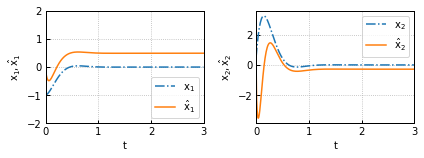

In [14]:
fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

Td = np.arange(0, 3, 0.01)
X0 = [-1, 0.5]
d = 0.5*(T>0)

# 状態フィードバック
regulator_poles = [-5+5j, -5-5j]
F = -acker(P.A, P.B, regulator_poles)
Gsf = ss(P.A + P.B*F, P.B, np.eye(2), [[0],[0]])

x, t = initial(Gsf, Td, X0)
ax[0].plot(t, x[:, 0], ls='-.', label='${x}_1$')
ax[1].plot(t, x[:, 1], ls='-.', label='${x}_2$')

# 入力 u = Fx
u = [ [F[0,0]*x[i,0]+F[0,1]*x[i,1]] for i in range(len(x))]
# 出力 y = Cx+d
y = x[:, 0]+d
Obs = ss(P.A + L*P.C, np.c_[P.B, -L], np.eye(2), [[0,0],[0,0]] )

xhat, t, x0 = lsim(Obs, np.c_[u, y], T, [0, 0])
ax[0].plot(t, xhat[:, 0], label='$\hat{x}_1$')
ax[1].plot(t, xhat[:, 1], label='$\hat{x}_2$')

for i in [0, 1]:
    ax[i].grid(ls=':')
    ax[i].set_xlim([0, 3])
    ax[i].set_xlabel('t')
    ax[i].legend()

ax[0].set_ylim([-2, 2])
ax[0].set_ylabel('$x_1, \hat{x}_1$')
ax[1].set_ylabel('$x_2, \hat{x}_2$')

fig.tight_layout()
#fig.savefig("dis_obs.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

In [15]:
# オブザーバ極
observer_poles=[-15+5j,-15-5j, -3] 

# オブザーバゲインの設計（状態フィードバックの双対）
E = [[0], [0]]
Abar = np.r_[ np.c_[P.A, E], np.zeros((1,3))] 
Bbar = np.c_[ P.B.T, np.zeros((1,1)) ].T
Cbar = np.c_[ P.C, 1 ]

Lbar = -acker(Abar.T, Cbar.T, observer_poles).T
print(Lbar)

Fbar = np.c_[ F, 0 ]

# Obs = ss(Abar+Bbar*Fbar+Lbar*Cbar, -Lbar, np.eye(3), [[0],[0],[0]] )
Aob = Abar + Lbar*Cbar
Bob = np.c_[Bbar, -Lbar]
Obs = ss(Aob, Bob, np.eye(3), [[0,0],[0,0],[0,0]] )

[[ 149.5]
 [-526. ]
 [-187.5]]


In [16]:
pole(Obs)

array([-15.+5.j, -15.-5.j,  -3.+0.j])

(-0.5, 1)

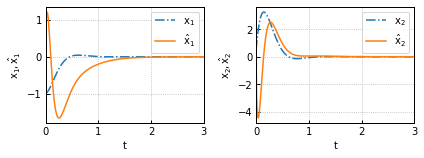

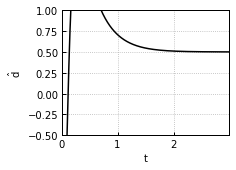

In [17]:
fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

Td = np.arange(0, 3, 0.01)
X0 = [-1, 0.5]
d = 0.5*(T>0)
x, t = initial(Gsf, Td, X0)
ax[0].plot(t, x[:, 0], ls='-.', label='${x}_1$')
ax[1].plot(t, x[:, 1], ls='-.', label='${x}_2$')


# 入力 u = Fx
u = [ [F[0,0]*x[i,0]+F[0,1]*x[i,1]] for i in range(len(x))]
# 出力 y = Cx+d
y = x[:, 0]+d
xhat, t, x0 = lsim(Obs, np.c_[u, y], T, [0, 0, 0])
#xhat, t, x0 = lsim(Obs, x[:, 0]+d, T, [0, 0, 0])
ax[0].plot(t, xhat[:, 0], label='$\hat{x}_1$')
ax[1].plot(t, xhat[:, 1], label='$\hat{x}_2$')

for i in [0, 1]:
    ax[i].grid(ls=':')
    ax[i].set_xlim([0, 3])
    ax[i].set_xlabel('t')
    ax[i].legend()

ax[0].set_ylabel('$x_1, \hat{x}_1$')
ax[1].set_ylabel('$x_2, \hat{x}_2$')

fig.tight_layout()
# fig.savefig("dis_obs2.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t, xhat[:, 2], label='$\hat{x}_2$', color='k')
ax.grid(ls=':')
ax.set_xlabel('t')
ax.set_ylabel('$\hat{d}$')
ax.set_ylim([-0.5, 1])

外乱 0.5 が推定できている

## ロバスト制御

In [18]:
g  = 9.81                # 重力加速度[m/s^2]
l  = 0.2                 # アームの長さ[m]
M  = 0.5                 # アームの質量[kg]
mu = 1.5e-2              # 粘性摩擦係数
J  = 1.0e-2              # 慣性モーメント

P = tf( [0,1], [J, mu, M*g*l] )

ref = 30 # 目標角度 [deg]

### 乗法的不確かさ

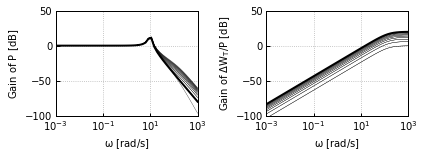

In [19]:
# 垂直駆動アームのノミナルモデル
Pn = tf( [0,1], [J, mu, M*g*l] )

# Pn = tf( [0, 1], [1, 1])
# 不確かさ
delta = np.arange(-1, 1 , 0.1)
WT = tf( [10, 0], [1, 150])

fig, ax = plt.subplots(1, 2, figsize=(6,2.3))
# fig, ax = plt.subplots(1, 2)

for i in range(len(delta)):
    # 不確かさをもつ制御対象
    P = (1 + WT*delta[i])*Pn
    gain, _, w = bode(P, logspace(-3,3), Plot=False)

    ax[0].semilogx(w, 20*np.log10(gain), color = 'k', lw = 0.3)
    
    # 乗法的不確かさ
    DT = (P - Pn)/Pn
    gain, _, w = bode(DT, logspace(-3,3), Plot=False)

    ax[1].semilogx(w, 20*np.log10(gain), color = 'k', lw = 0.3)

gain, phase, w = bode(Pn, logspace(-3,3), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), lw =2, color='k')

gain, phase, w = bode(WT, logspace(-3,3), Plot=False)
ax[1].semilogx(w, 20*np.log10(gain), lw =2, color='k')

ax[0].set_ylim(-100, 50)
ax[1].set_ylim(-100, 50)
bodeplot_set(ax)
ax[0].set_xlabel('$\omega$ [rad/s]')
ax[0].set_ylabel('Gain of $P$ [dB]')
ax[1].set_ylabel('Gain of $\Delta W_T/P$ [dB]')
#ax.grid(which="both", ls=':')
#ax.set_ylabel('Gain [dB]')
#ax.set_xlabel('$\omega$ [rad/s]')

fig.tight_layout()
# fig.savefig("robust_plant.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### 混合感度問題

K= 
    7.21 s^4 + 1098 s^3 + 3259 s^2 + 1.081e+05 s + 9.032e+04
---------------------------------------------------------------
s^5 + 165.1 s^4 + 2448 s^3 + 2.449e+04 s^2 + 2.273e+04 s + 5540

gamma = 0.9527651218302327


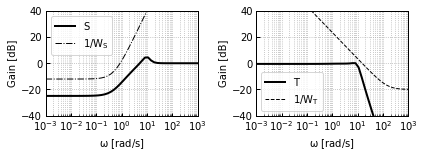

In [20]:
from control import mixsyn

WS = tf( [0, 1], [1, 1, 0.25]) # 感度関数に対する重み関数 
WU = tf(1, 1)
WT = tf( [10, 0], [1, 150]) # 相補感度関数に対する重み関数

# 混合感度問題
K, _, gamma = mixsyn(Pn, w1=WS , w2=WU, w3=WT) 

print('K=', ss2tf(K))
print('gamma =', gamma[0])

fig, ax = plt.subplots(1, 2, figsize=(6,2.3))

# 感度関数
Ssys = feedback(1, Pn*K)
gain, _, w = bode(Ssys, logspace(-3,3), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), ls= '-', lw =2, label='$S$', color='k')

gain, _, w = bode(1/WS, logspace(-3,3), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), ls= '-.', lw =1, label='$1/W_S$', color='k')

# 相補感度関数
Tsys = feedback(Pn*K, 1)
gain, _, w = bode(Tsys, logspace(-3,3), Plot=False)
ax[1].semilogx(w, 20*np.log10(gain), ls = '-', lw =2, label='$T$', color='k')

gain, _, w = bode(1/WT, logspace(-3,3), Plot=False)
ax[1].semilogx(w, 20*np.log10(gain), ls= '--', lw =1, label='$1/W_T$', color='k')

for i in range(2):
    ax[i].set_ylim(-40, 40)
    ax[i].legend()
    ax[i].grid(which="both", ls=':')
    ax[i].set_ylabel('Gain [dB]')
    ax[i].set_xlabel('$\omega$ [rad/s]')

fig.tight_layout()
# fig.savefig("robust_design.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

(0, 60)

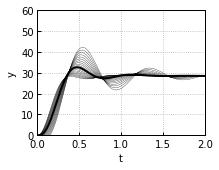

In [21]:
fig, ax = plt.subplots(figsize=(3, 2.3))

for i in range(len(delta)):
    P = (1 + WT*delta[i])*Pn
    Gyr = feedback(P*K, 1)
    
    y, t = step(Gyr, np.arange(0,5,0.01))

    ax.plot(t, y*ref, color ='k', lw =0.3)

Gyr = feedback(Pn*K, 1)
y, t = step(Gyr, np.arange(0,5,0.01))
ax.plot(t, y*ref, lw =2, color='k')

plot_set(ax, 't', 'y')
ax.set_xlim(0, 2)
ax.set_ylim(0, 60)

# fig.savefig("robust_step.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### PID制御との比較

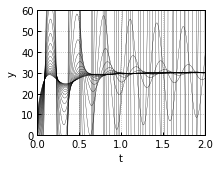

In [22]:
kp = 2
kd = 0.1
ki = 10

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(3,2.3))

for i in range(len(delta)):
    Kpid = tf([kd, kp, ki], [1, 0])
    
    P = (1 + WT*delta[i])*Pn
    Gyr = feedback(P*Kpid, 1)
    y, t = step(Gyr, np.arange(0,5,0.01))
    ax.plot(t, y*ref, color ='k', lw =0.3)
      
ax.set_xlim(0, 2)
ax.set_ylim(0, 60)
plot_set(ax, 't', 'y')

# fig.savefig("robust_comp.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

ナイキスト線図で不確かさの影響を確認する

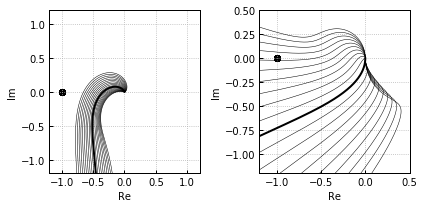

In [23]:
fig, ax = plt.subplots(1,2, figsize=(6, 3))

for i in range(len(delta)):
# ロバスト制御：閉ループ系が安定になる
    
    P = (1 + WT*delta[i])*Pn

    x, y, _ = nyquist(P*K, logspace(-3,5,1000), Plot=False)
    ax[0].plot(x, y, lw = 0.5, color='k')
    #ax[0].plot(x, -y, ls='--', color='k')
    ax[0].scatter(-1, 0, color='k')
    plot_set(ax[0], 'Re', 'Im')

# PID制御：閉ループ系が不安定になる
    xpid, ypid, _ = nyquist(P*Kpid, logspace(-3,5,1000), Plot=False)
    ax[1].plot(xpid, ypid, lw = 0.5, color='k')
    #ax[1].plot(xpid, -ypid, ls='--', color='k')
    ax[1].scatter(-1, 0, color='k')
    plot_set(ax[1], 'Re', 'Im')

x, y, _ = nyquist(Pn*K, logspace(-3,5,1000), Plot=False)
ax[0].plot(x, y, lw = 2, color='k')
ax[0].set_xlim(-1.2, 1.2)
ax[0].set_ylim(-1.2, 1.2)

xpid, ypid, _ = nyquist(Pn*Kpid, logspace(-3,5,1000), Plot=False)
ax[1].plot(xpid, ypid, lw = 2, color='k')
ax[1].set_xlim(-1.2, 0.5)
ax[1].set_ylim(-1.2, 0.5)
fig.tight_layout()

# fig.savefig("nyquist_robust.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

左：ロバスト制御，右：PID制御

### おまけ

In [24]:
from control import augw, hinfsyn
G = augw(P, w1=WS, w2=WU, w3=WT)

In [25]:
k, cl, gam, ro= hinfsyn(G, 1, 1)

## ディジタル実装

In [26]:
P = tf([0, 1], [0.5, 1])
print('連続時間システム',P)

連続時間システム 
    1
---------
0.5 s + 1



In [27]:
ts = 0.2

Pd1 = c2d(P, ts, method='zoh')
print('離散時間システム（zoh）', Pd1)

Pd2 = c2d(P, ts, method='tustin')
print('離散時間システム（tustin）',Pd2)

離散時間システム（zoh） 
  0.3297
----------
z - 0.6703

dt = 0.2

離散時間システム（tustin） 
0.1667 z + 0.1667
-----------------
    z - 0.6667

dt = 0.2



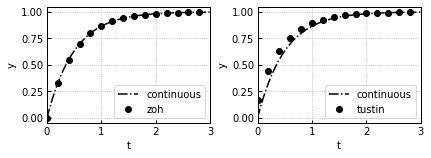

In [28]:
fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

Tc = np.arange(0, 3, 0.01)
y, t = step(P, Tc)
ax[0].plot(t, y, ls='-.', label='continuous', color='k')
ax[1].plot(t, y, ls='-.', label='continuous', color='k')


Td = np.arange(0, 3, ts)
y, t = step(Pd1, Td)
ax[0].plot(t, y, ls='', marker='o', label='zoh', color='k')

y, t = step(Pd2, Td)
ax[1].plot(t, y, ls='', marker='o', label='tustin', color='k')

for i in [0, 1]:
    plot_set(ax[i], 't', 'y', 'best')
    ax[i].set_xlim([0, 3])

fig.tight_layout()
# fig.savefig("c2d_step.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

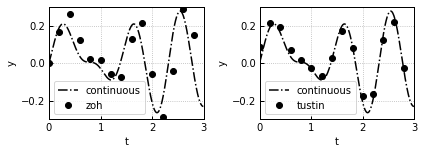

In [29]:
fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

Tc = np.arange(0, 3, 0.01)
Uc = 0.5 * np.sin(6*Tc) + 0.5 * np.cos(8*Tc)

y, t, x0 = lsim(P, Uc, Tc)
ax[0].plot(t, y, ls='-.', label='continuous', color='k')
ax[1].plot(t, y, ls='-.', label='continuous', color='k')


T = np.arange(0, 3, ts)
U = 0.5 * np.sin(6*T) + 0.5 * np.cos(8*T)

y, t, x0 = lsim(Pd1, U, T)
ax[0].plot(t, y, ls='', marker='o', label='zoh', color='k')

y, t, x0 = lsim(Pd2, U, T)
ax[1].plot(t, y, ls='', marker='o', label='tustin', color='k')

for i in [0, 1]:
    plot_set(ax[i], 't', 'y', 'best')
    ax[i].set_xlim([0, 3])
    ax[i].set_ylim([-0.3, 0.3])

fig.tight_layout()
# fig.savefig("c2d_time.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

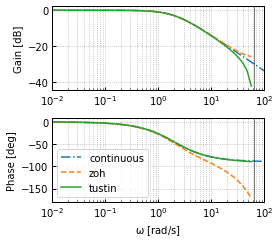

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(P, np.logspace(-2,2), Plot=False)
pltargs = {'ls': '-.', 'label': 'continuous'}
ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
ax[1].semilogx(w, phase*180/np.pi, **pltargs)

gain, phase, w = bode(Pd1, np.logspace(-2,2), Plot=False)
pltargs = {'ls': '--', 'label': 'zoh'}
ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
ax[1].semilogx(w, phase*180/np.pi, **pltargs)


gain, phase, w = bode(Pd2, np.logspace(-2,2), Plot=False)
pltargs = {'ls': '-', 'label': 'tustin'}
ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
ax[1].semilogx(w, phase*180/np.pi, **pltargs)

bodeplot_set(ax, 3)

ax[0].axvline(np.pi/ts, lw = 0.5, c ='k')
ax[1].axvline(np.pi/ts, lw = 0.5, c ='k')

fig.tight_layout()
#fig.savefig("c2d_bode.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

離散時間システム（zoh） 
  0.09516
----------
z - 0.9048

dt = 0.05

離散時間システム（tustin） 
0.04762 z + 0.04762
-------------------
    z - 0.9048

dt = 0.05



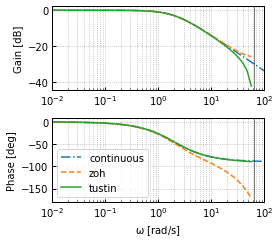

In [31]:
ts = 0.05

Pd1 = c2d(P, ts, method='zoh')
print('離散時間システム（zoh）', Pd1)

Pd2 = c2d(P, ts, method='tustin')
print('離散時間システム（tustin）',Pd2)

fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(P, np.logspace(-2,2), Plot=False)
pltargs = {'ls': '-.', 'label': 'continuous'}
ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
ax[1].semilogx(w, phase*180/np.pi, **pltargs)

gain, phase, w = bode(Pd1, np.logspace(-2,2), Plot=False)
pltargs = {'ls': '--', 'label': 'zoh'}
ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
ax[1].semilogx(w, phase*180/np.pi, **pltargs)


gain, phase, w = bode(Pd2, np.logspace(-2,2), Plot=False)
pltargs = {'ls': '-', 'label': 'tustin'}
ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
ax[1].semilogx(w, phase*180/np.pi, **pltargs)

bodeplot_set(ax, 3)

ax[0].axvline(np.pi/ts, lw = 0.5, c ='k')
ax[1].axvline(np.pi/ts, lw = 0.5, c ='k')

fig.tight_layout()
# fig.savefig("c2d_bode2.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)